In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import gzip
from pybedtools import BedTool
import os
from tqdm import tqdm
from scipy.stats import zscore
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr

from sklearn.preprocessing import OneHotEncoder

import rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.robjects.packages as rpackages


def load_ebpmf_gene(gene_id, n):
    readRDS = ro.r['readRDS']
    df = readRDS(f'/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/gao_models/RDS/{str(n)}/{gene_id}.rds')
    with (ro.default_converter + pandas2ri.converter).context():
        pd_from_r_df = ro.conversion.get_conversion().rpy2py(df)

    output = pd_from_r_df

    return output


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


In [4]:
metadata = pd.read_csv('../code/gao_data/metadata/merged_metadata.tab.gz', sep='\t', index_col=0)
# EL = pd.read_csv('../code/ebpmf_models/gao_models/tables/snmf5_EL.tab.gz', sep='\t', index_col=3)
# EL = pd.read_csv('ebpmf_models/gao_models/tables/transcript.snmf_5.EL.bed.gz', sep='\t', index_col=3)
samples = EL.columns[5:]


ad_samples = pd.Index(metadata.loc[metadata.cogdx == 4].index).intersection(samples)
control_samples = pd.Index(metadata.loc[metadata.cogdx == 1].index).intersection(samples)

ad_control_samples = list(ad_samples) + list(control_samples)

dlpc_samples = pd.Index(metadata.loc[metadata.tissue_id == 'DLPC'].index).intersection(samples)
ac_samples = pd.Index(metadata.loc[metadata.tissue_id == 'AC'].index).intersection(samples)
pcc_samples = pd.Index(metadata.loc[metadata.tissue_id == 'PCC'].index).intersection(samples)

In [5]:
def prepare_ad_metaplot(gene, samples_1, samples_2, AC, DLPC, PCC):
    counts = pd.read_csv(f'../code/gao_data/counts/{gene}.csv.gz', index_col=0)

    
    
    
    
    rpkm_ba9 = 1e9*counts.divide(counts.sum(axis=1), axis=0)/counts.shape[1]

    first_pos = int(counts.columns[0].split(':')[1])
    coords = [int(x.split(':')[1]) for x in counts.columns]
    
    mean_counts_1 = np.array(np.log1p(rpkm_ba9).loc[pd.Index(samples_1)].mean(axis=0))
    mean_counts_2 = np.array(np.log1p(rpkm_ba9).loc[pd.Index(samples_2)].mean(axis=0))

    mean_counts_1_AC = np.array(np.log1p(rpkm_ba9).loc[pd.Index(samples_1).intersection(pd.Index(AC))].mean(axis=0))
    mean_counts_2_AC = np.array(np.log1p(rpkm_ba9).loc[pd.Index(samples_2).intersection(pd.Index(AC))].mean(axis=0))

    mean_counts_1_DLPC = np.array(np.log1p(rpkm_ba9).loc[pd.Index(samples_1).intersection(pd.Index(DLPC))].mean(axis=0))
    mean_counts_2_DLPC = np.array(np.log1p(rpkm_ba9).loc[pd.Index(samples_2).intersection(pd.Index(DLPC))].mean(axis=0))

    mean_counts_1_PCC = np.array(np.log1p(rpkm_ba9).loc[pd.Index(samples_1).intersection(pd.Index(PCC))].mean(axis=0))
    mean_counts_2_PCC = np.array(np.log1p(rpkm_ba9).loc[pd.Index(samples_2).intersection(pd.Index(PCC))].mean(axis=0))

    out_dir = {'first_position':first_pos,
               'coords':coords,
               'ad_counts':mean_counts_1,
               'control_counts':mean_counts_2,
               'ad_counts_AC':mean_counts_1_AC,
               'control_counts_AC':mean_counts_2_AC,
               'ad_counts_DLPC':mean_counts_1_DLPC,
               'control_counts_DLPC':mean_counts_2_DLPC,
               'ad_counts_PCC':mean_counts_1_PCC,
               'control_counts_PCC':mean_counts_2_PCC,
              }
    
    return out_dir

In [8]:


def plot_gene_counts(gene_dir, tissue = None, plot_var = True, smooth=50, xlim1 = False, xlim2=False, ylim=False, var_h = 3, ax=None,
                    colores = ['black', 'gray', 'silver'], linewidth=1):
    
    # out_dir = {'var':var_id,
    #            'var_pos':var_loc,
    #            'first_position':first_pos,
    #            'ref_allele':ref,
    #            'alt_allele':alt,
    #            'coords':coords,
    #            'alts_coverage':mean_counts_1,
    #            'het_coverage':mean_counts_2,
    #            'ref_coverage':mean_counts_3}


    if tissue is None:
        ad_counts = gene_dir['ad_counts']
        control_counts = gene_dir['control_counts']
    else:
        ad_counts = gene_dir[f'ad_counts_{tissue}']
        control_counts = gene_dir[f'control_counts_{tissue}']
    
    coords = gene_dir['coords']
    first_pos = gene_dir['first_position']

    smoothed_coords = [np.mean(coords[i:i+smooth]) for i in range(len(coords))]
    
    smoothed_mean_ad = [np.mean(ad_counts[i:i+smooth]) for i in range(len(ad_counts))]
    smoothed_mean_ct = [np.mean(control_counts[i:i+smooth]) for i in range(len(control_counts))]
    
    if ax is None:
        fig, ax = plt.subplots(figsize = (10, 1.5))

    

    ax.plot(smoothed_coords, smoothed_mean_ad,  label = f'AD', c=colores[1], linewidth=linewidth)
    ax.plot(smoothed_coords, smoothed_mean_ct,  label = f'Control', c=colores[0], linewidth=linewidth)
    
    ax.legend(frameon=False, bbox_to_anchor=(1, 1.1))
    # ax.set_xlabel(chrom)
    # ax.set_xticks([])
    

    ax.set_ylabel('mean\ncounts')

    if xlim1 and xlim2:
        ax.set_xlim([first_pos + xlim1, first_pos + xlim2])


import sys
sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code')
sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code/scripts')
from get_unique_region_counts import *
from sNMF_plots import *
from get_isoforms import *
from get_unique_region_counts import *
from plot_factors import *
from collect_snmf_isoforms import *

def load_ebpmf_gene(gene_id):
    readRDS = ro.r['readRDS']
    df = readRDS(f'/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/RDS/{gene_id}.rds')
    with (ro.default_converter + pandas2ri.converter).context():
        pd_from_r_df = ro.conversion.get_conversion().rpy2py(df)

    output = pd_from_r_df

    return output

colores = np.array(sns.color_palette("tab10"))


def plot_factors_wrapper(rds, gene, ebpmf='ebpmf_10', strand='plus', colores=None, figsize=None, lm=True, factor_list = None, 
                         ax = None, xlim=None, plot_coords = False, lwidth=3, mute_y_axis = False):
    EF = pd.DataFrame(rds[ebpmf]['train_fit']['EF_smooth'][1:-1,:])
    EF.index = rds[ebpmf]['coords']

    if xlim is None:
        
        xlim1 = int(rds[ebpmf]['coords'][0].split(':')[1])-1000
        xlim2 = int(rds[ebpmf]['coords'][-1].split(':')[1])+1000
        xlim = (xlim1, xlim2)

    # xlim = (xlim1, xlim2)
    # print(xlim1, xlim2)
    
    EF.columns = [f'factor{str(i+1)}' for i in range(EF.shape[1])]

    if factor_list is not None:
        EF = EF[factor_list]
        EF = pd.DataFrame(EF)
        K = EF.shape[1]
        EF.columns = [f'factor{str(i)}' for i in range(1, K+1)]
    
    for factor in EF.columns:
        
        if lm:
            y = factor_lm(EF[factor], strand)
        else:
            y = np.array(EF[factor])
        EF[factor] = y
    plot_factor_tracks(EF/EF.quantile(0.99, axis=0), gene, EF.shape[1], colores = colores, figsize=figsize, ax=ax, 
                       xlim=xlim, plot_coords = plot_coords, mute_y_axis=mute_y_axis)


def plot_factor_tracks(EF, gene, K, title=None, fill=True, smooth=False, colores = None, q=0.99, figsize=None, ax=None, xlim=None, 
                       plot_coords=None, lwidth=None, mute_y_axis=False):

    EF = np.minimum(EF/EF.quantile(q, axis=0), 1)

    if colores is None:
        if K <= 5:
            colores = ['tab:blue', 'tab:orange', 'tab:green', 'goldenrod', 'tab:red'] 
        else:
            colores = sns.color_palette("tab10")
    
    if K <= 3:
        S = K
    else:
        S = K*0.8

    if figsize is None:
        figsize=(15, S)

    if ax is None:
        fig, ax = plt.subplots(nrows = K, figsize=figsize, gridspec_kw={'height_ratios': [2]*K, 
                                                                               'wspace': 0.3, 'hspace': 0.3})

    start = int(EF.index[0].split(':')[1])
    end = int(EF.index[-1].split(':')[1])
    length = EF.shape[0]
    
    coords = np.linspace(start, end, num=length)
    
    for i in range(K):
        factor = f'factor{i+1}'
        scaled_y = EF[factor]#/np.max(EF[factor])
        if fill:
            ax[i].fill_between(coords, np.zeros(len(coords)), scaled_y, color=colores[i], alpha=0.3)
#         else:
        ax[i].plot(coords, scaled_y, c=colores[i], alpha=0.9, linewidth=lwidth)
        
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        if (i < K-1) or (not plot_coords):
            ax[i].set_xticks([])
            ax[i].spines['bottom'].set_visible(False)

        if mute_y_axis:
            ax[i].spines['left'].set_visible(False)
            ax[i].set_yticks([])

        ax[i].set_xlim([xlim[0], xlim[1]])
        
        #ax[i].text(start+((end-start)*1.1), 0.9, factor, size=12)

    
        
    if title:
        fig.suptitle(title, fontsize=12, x=0.5, y=1.1)



def plot_isoform_annotations(annotation_exons, gene, colores=None, start=None, end=None, figsize=None, lwidth=5, iso_order=None, axes=None, xlim=None):

    gene_exons = annotation_exons.loc[annotation_exons.gene_id == gene]

    if iso_order is None:
        isoforms = sorted(gene_exons.transcript_id.unique())
    else:
        isoforms = [gene + '.' + x for x in iso_order]

    isoform_dict = {}
    for i, iso in enumerate(isoforms):
        isoform_name = f'isoform_{str(i+1)}'
        df = gene_exons.loc[gene_exons.transcript_id == iso].copy()
        df['transcript_id'] =  f'{gene}.{isoform_name}'
        isoform_dict.update({isoform_name:{'df':df}})

    chrom = list(annotation_exons.chrom)[0]
    if start is None:
        start = str(np.min([int(list(gene_exons.start)[0]), int(list(gene_exons.start)[0])]) - 1000)
    if end is None:
        end = str(np.max([int(list(gene_exons.end)[-1]), int(list(gene_exons.end)[-1])]) + 1000)

    coords = [f'{chrom}:{start}', f'{chrom}:{end}']
    print(coords)

    # print(isoform_dict)

    plot_gene_isoforms(isoform_dict, coords, color_list = colores, figsize=figsize, lwidth=lwidth, axes=axes, xlim=xlim)



def plot_gene_isoforms(isoforms_dict, coordinates, color_list = None, axes=None, figsize=None, lwidth=5, xlim=None):

    print(coordinates[0])
    print(coordinates[-1])
    if xlim is None:
        print('booyah')
        xlim1 = int(coordinates[0].split(':')[1])
        xlim2 = int(coordinates[-1].split(':')[1])
    else:
        xlim1 = xlim[0]
        xlim2 = xlim[1]

    xlim=(xlim1, xlim2)
    

    if color_list is None:
        color_list = sns.color_palette("tab10")

    K = len(isoforms_dict)

    if figsize is None:
        figsize=(20, 3)

    if axes is None:
        fig, axes = plt.subplots(K, 1, figsize=figsize)

    for i in range(K):
        isoform_df = isoforms_dict[f'isoform_{str(i+1)}']['df']
        # print(isoform_df)
        ax = axes[i]
        color = color_list[i]
        plot_isoform(isoform_df, ax, color, xlim[0], xlim[1], lwidth=lwidth)


def plot_isoform(isoform_df, ax, color, xlim1, xlim2, lwidth):
    # print(isoform_df)
    is_first = True
    for idx, row in isoform_df.iterrows():
        start = int(row.start)
        end = int(row.end)
        if is_first:
            first = end
            is_first = False
    
        ax.fill_between([start, end], [0, 0], [1, 1], color = color, zorder=2)
    
    ax.plot([first, start], [0.5, 0.5], c=color, linewidth=lwidth)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['bottom', 'top', 'right', 'left']].set_visible(False)
    ax.set_xlim([xlim1, xlim2])

    # print(xlim1, xlim2)


loading modules
some more modules
custom-made modules
finished loading modules


In [7]:
rds = load_ebpmf_gene('ENSG00000067057', 69)

In [14]:
EL = pd.DataFrame(rds['snmf_5']['ebpmf']['EL'])
EL.index = rds['kept_samples']
EL.columns = [f'factor_{str(i+1)}' for i in range(5)]

EF = pd.DataFrame(rds['snmf_5']['ebpmf']['EF_smooth'])
EF.columns = [f'factor_{str(i+1)}' for i in range(5)]

In [21]:
snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/gao_models/tables/snmf_5.merged_isoforms.exons.sorted.bed.gz'
snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
                                                 'transcript_id', 'strand', 'factors', 'exon_id'])

In [22]:
LF_ad = np.array(EL.loc[ad_samples.intersection(dlpc_samples)]).dot(np.array(np.array(rds['snmf_5']['ebpmf']['EF_smooth']).T))
LF_ctrl = np.array(EL.loc[control_samples.intersection(dlpc_samples)]).dot(np.array(np.array(rds['snmf_5']['ebpmf']['EF_smooth']).T))

LF_ad_norm = np.divide(LF_ad.T, np.quantile(LF_ad, 0.99, axis=1)).T
LF_ctrl_norm = np.divide(LF_ctrl.T, np.quantile(LF_ctrl, 0.99, axis=1)).T

In [23]:
top_samples_ctrl = EL.loc[control_samples.intersection(dlpc_samples), 'factor_4'].sort_values().index[-10:]
top_samples_ad = EL.loc[ad_samples.intersection(dlpc_samples), 'factor_4'].sort_values().index[-10:]


/tmp/jobs/42979454/ipykernel_34040/97120585.py:10: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  top_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc['R9064073-DLPFC'])[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/97120585.py:11: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  bottom_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc['R6796261-DLPFC'])[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/97120585.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0))[5000:8000], c='tab:red')
/tmp/jobs/42979454/ipykernel_34040/97120585.py:20: FutureWarning: Support for axis=1 in DataFrame.rolling i

['chr10:3066503', 'chr10:3137800']
chr10:3066503
chr10:3137800


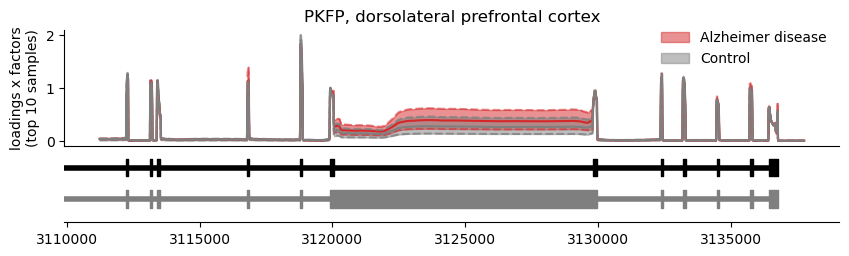

In [44]:
fig, axes = plt.subplots(nrows = 4, figsize=(10, 2.5), gridspec_kw={'height_ratios': [6, 1, 1, 0.1], 'hspace': 0.3})
LF_ad_norm_df = pd.DataFrame(LF_ad_norm)
LF_ad_norm_df.index = ad_samples.intersection(dlpc_samples)


LF_ctrl_norm_df = pd.DataFrame(LF_ctrl_norm)
LF_ctrl_norm_df.index = control_samples.intersection(dlpc_samples)

ax = axes[0]
top_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc['R9064073-DLPFC'])[5000:8000]
bottom_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc['R6796261-DLPFC'])[5000:8000]
ax.fill_between(range(len(top_ad)), bottom_ad, top_ad, alpha=0.5, color='tab:red', label='Alzheimer disease')
ax.plot(top_ad, c='tab:red', linestyle='--', alpha=0.5)
ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0))[5000:8000], c='tab:red')
ax.plot(bottom_ad, c='tab:red', linestyle='--', alpha=0.5)


# ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0)))

top_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc['R7423003-DLPFC'])[5000:8000]
bottom_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc['R3110303-DLPFC'])[5000:8000]
ax.fill_between(range(len(top_ad)), bottom_ctrl, top_ctrl, alpha=0.5, color='tab:gray', label='Control')


ax.plot(top_ctrl, c='tab:gray', linestyle='--', alpha=0.75)
ax.plot(np.array(LF_ctrl_norm_df.loc[top_samples_ctrl].rolling(5, axis=1).median().median(axis=0))[5000:8000], c='tab:gray')
ax.plot(bottom_ctrl, c='tab:gray', linestyle='--', alpha=0.75)

ax.legend(frameon=False, bbox_to_anchor=(1, 1.1))

# ax.set_xlim((3111233, 3137801))

top_samples_ctrl = EL.loc[control_samples.intersection(dlpc_samples), 'factor_4'].sort_values().index[-10:]



plot_isoform_annotations(snmf_exons.loc[snmf_exons.transcript_id.isin(['ENSG00000067057.isoform_1', 'ENSG00000067057.isoform_4'])], 
                         'ENSG00000067057', colores = ['black', 'tab:gray'], axes=axes[1:-1], lwidth=4, xlim=(3111233, 3137801))

axes[1].set_xlim((3109900, 3139101))
axes[2].set_xlim((3109900, 3139101))


axes[-1].set_xlim([3109900, 3139101])

axes[-1].set_yticks([])
xticks = [3110000, 3115000, 3120000, 3125000, 3130000, 3135000]
axes[-1].set_xticks(xticks)
axes[-1].set_xticklabels([str(x) for x in xticks])
axes[-1].spines[['top', 'right', 'left']].set_visible(False)
axes[0].set_xticks([])
axes[0].spines[['top', 'right']].set_visible(False)
axes[0].set_ylabel('loadings x factors\n(top 10 samples)')
axes[0].set_title('PKFP, dorsolateral prefrontal cortex')
# axes[-1].set_xticks(xticks)
# xtick_labels = [str(int(x)) for x in xticks]
# axes[-1].set_xticklabels(xtick_labels)

plt.savefig('../code/scratch_figures/figure5/PKFP_DLPC_LF.zoom.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/PKFP_DLPC_LF.zoom.png', bbox_inches='tight', dpi=500)

/tmp/jobs/42979454/ipykernel_34040/1132889533.py:10: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  top_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc['R9064073-DLPFC'])#[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/1132889533.py:11: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  bottom_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc['R6796261-DLPFC'])#[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/1132889533.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0)),#[5000:8000],
/tmp/jobs/42979454/ipykernel_34040/1132889533.py:21: FutureWarning: Support for axis=1 in DataFrame.rolling is

['chr10:3066503', 'chr10:3137800']
chr10:3066503
chr10:3137800
booyah


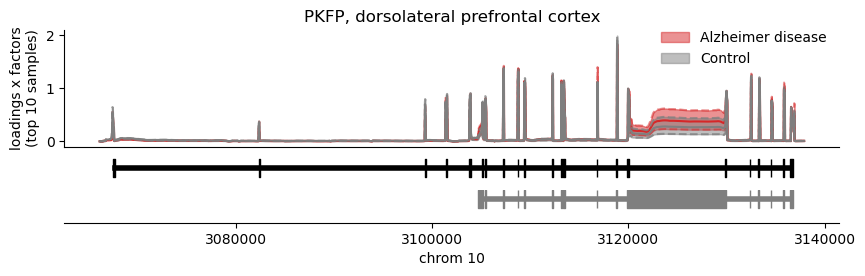

In [51]:
fig, axes = plt.subplots(nrows = 4, figsize=(10, 2.5), gridspec_kw={'height_ratios': [6, 1, 1, 0.1], 'hspace': 0.3})
LF_ad_norm_df = pd.DataFrame(LF_ad_norm)
LF_ad_norm_df.index = ad_samples.intersection(dlpc_samples)


LF_ctrl_norm_df = pd.DataFrame(LF_ctrl_norm)
LF_ctrl_norm_df.index = control_samples.intersection(dlpc_samples)

ax = axes[0]
top_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc['R9064073-DLPFC'])#[5000:8000]
bottom_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc['R6796261-DLPFC'])#[5000:8000]
ax.fill_between(range(len(top_ad)), bottom_ad, top_ad, alpha=0.5, color='tab:red', label='Alzheimer disease')
ax.plot(top_ad, c='tab:red', linestyle='--', alpha=0.5)
ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0)),#[5000:8000], 
        c='tab:red')
ax.plot(bottom_ad, c='tab:red', linestyle='--', alpha=0.5)


# ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0)))

top_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc['R7423003-DLPFC'])#[5000:8000]
bottom_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc['R3110303-DLPFC'])#[5000:8000]
ax.fill_between(range(len(top_ad)), bottom_ctrl, top_ctrl, alpha=0.5, color='tab:gray', label='Control')


ax.plot(top_ctrl, c='tab:gray', linestyle='--', alpha=0.75)
ax.plot(np.array(LF_ctrl_norm_df.loc[top_samples_ctrl].rolling(5, axis=1).median().median(axis=0)),#[5000:8000], 
        c='tab:gray')
ax.plot(bottom_ctrl, c='tab:gray', linestyle='--', alpha=0.75)

ax.legend(frameon=False, bbox_to_anchor=(1, 1.1))

# ax.set_xlim((3111233, 3137801))

top_samples_ctrl = EL.loc[control_samples.intersection(dlpc_samples), 'factor_4'].sort_values().index[-10:]



plot_isoform_annotations(snmf_exons.loc[snmf_exons.transcript_id.isin(['ENSG00000067057.isoform_1', 'ENSG00000067057.isoform_4'])], 
                         'ENSG00000067057', colores = ['black', 'tab:gray'], axes=axes[1:-1], lwidth=4)#, xlim=(3111233, 3137801))

# axes[1].set_xlim((3109900, 3139101))
# axes[2].set_xlim((3109900, 3139101))

axes[-3].set_xlim([3066503-4000, 3137800+3700])

axes[-2].set_xlim([3066503-4000, 3137800+3700])

axes[-1].set_xlim([3066503-4000, 3137800+3700])


xticks = [ 3080000, 3100000, 3120000, 3140000]
axes[-1].set_xticks(xticks)
axes[-1].set_xticklabels([str(x) for x in xticks])
axes[-1].spines[['top', 'right', 'left']].set_visible(False)
axes[-1].set_yticks([])
axes[-1].set_xlabel('chrom 10')
axes[0].set_xticks([])
axes[0].spines[['top', 'right']].set_visible(False)
axes[0].set_ylabel('loadings x factors\n(top 10 samples)')
axes[0].set_title('PKFP, dorsolateral prefrontal cortex')
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)

plt.savefig('../code/scratch_figures/figure5/PKFP_DLPC_LF.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/PKFP_DLPC_LF.png', bbox_inches='tight', dpi=500)

In [106]:
top_samples_ctrl = EL.loc[control_samples, ['factor_2', 'factor_4']].sum(axis=1).sort_values().index[-20:]
top_samples_ad = EL.loc[ad_samples, ['factor_2', 'factor_4']].sum(axis=1).sort_values().index[-20:]

LF_ad = np.array(EL.loc[ad_samples]).dot(np.array(np.array(rds['snmf_5']['ebpmf']['EF_smooth']).T))
LF_ctrl = np.array(EL.loc[control_samples]).dot(np.array(np.array(rds['snmf_5']['ebpmf']['EF_smooth']).T))

LF_ad_norm = np.divide(LF_ad.T, np.quantile(LF_ad, 0.99, axis=1)).T
LF_ctrl_norm = np.divide(LF_ctrl.T, np.quantile(LF_ctrl, 0.99, axis=1)).T

/tmp/jobs/42979454/ipykernel_34040/3619040216.py:10: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  top_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc[top_samples_ad[-1]])#[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/3619040216.py:11: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  bottom_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc[top_samples_ad[0]])#[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/3619040216.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0)),#[5000:8000],
/tmp/jobs/42979454/ipykernel_34040/3619040216.py:22: FutureWarning: Support for axis=1 in DataFrame.rolling

20


/tmp/jobs/42979454/ipykernel_34040/3619040216.py:23: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  bottom_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc[top_samples_ctrl[0]])#[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/3619040216.py:28: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  ax.plot(np.array(LF_ctrl_norm_df.loc[top_samples_ctrl].rolling(5, axis=1).median().median(axis=0)),#[5000:8000],


['chr10:3066503', 'chr10:3137800']
chr10:3066503
chr10:3137800
booyah


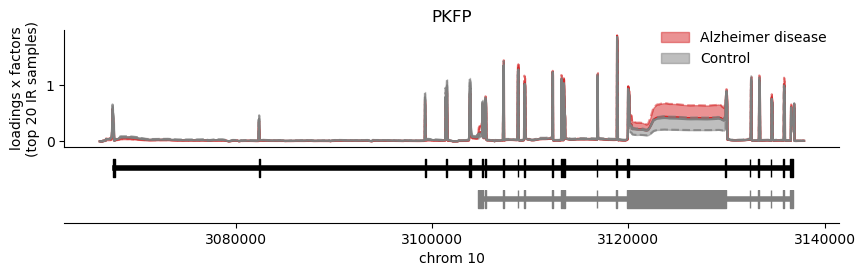

In [107]:


fig, axes = plt.subplots(nrows = 4, figsize=(10, 2.5), gridspec_kw={'height_ratios': [6, 1, 1, 0.1], 'hspace': 0.3})
LF_ad_norm_df = pd.DataFrame(LF_ad_norm)
LF_ad_norm_df.index = ad_samples#.intersection(dlpc_samples)


LF_ctrl_norm_df = pd.DataFrame(LF_ctrl_norm)
LF_ctrl_norm_df.index = control_samples#.intersection(dlpc_samples)

ax = axes[0]
top_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc[top_samples_ad[-1]])#[5000:8000]
bottom_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc[top_samples_ad[0]])#[5000:8000]
ax.fill_between(range(len(top_ad)), bottom_ad, top_ad, alpha=0.5, color='tab:red', label='Alzheimer disease')
ax.plot(top_ad, c='tab:red', linestyle='--', alpha=0.5)
ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0)),#[5000:8000], 
        c='tab:red')
ax.plot(bottom_ad, c='tab:red', linestyle='--', alpha=0.5)

print(len(top_samples_ad))

# ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0)))

top_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc[top_samples_ctrl[-1]])#[5000:8000]
bottom_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc[top_samples_ctrl[0]])#[5000:8000]
ax.fill_between(range(len(top_ad)), bottom_ctrl, top_ctrl, alpha=0.5, color='tab:gray', label='Control')


ax.plot(top_ctrl, c='tab:gray', linestyle='--', alpha=0.75)
ax.plot(np.array(LF_ctrl_norm_df.loc[top_samples_ctrl].rolling(5, axis=1).median().median(axis=0)),#[5000:8000], 
        c='tab:gray')
ax.plot(bottom_ctrl, c='tab:gray', linestyle='--', alpha=0.75)

ax.legend(frameon=False, bbox_to_anchor=(1, 1.1))

# ax.set_xlim((3111233, 3137801))





plot_isoform_annotations(snmf_exons.loc[snmf_exons.transcript_id.isin(['ENSG00000067057.isoform_1', 'ENSG00000067057.isoform_4'])], 
                         'ENSG00000067057', colores = ['black', 'tab:gray'], axes=axes[1:-1], lwidth=4)#, xlim=(3111233, 3137801))

# axes[1].set_xlim((3109900, 3139101))
# axes[2].set_xlim((3109900, 3139101))

axes[-3].set_xlim([3066503-4000, 3137800+3700])

axes[-2].set_xlim([3066503-4000, 3137800+3700])

axes[-1].set_xlim([3066503-4000, 3137800+3700])


xticks = [ 3080000, 3100000, 3120000, 3140000]
axes[-1].set_xticks(xticks)
axes[-1].set_xticklabels([str(x) for x in xticks])
axes[-1].spines[['top', 'right', 'left']].set_visible(False)
axes[-1].set_yticks([])
axes[-1].set_xlabel('chrom 10')
axes[0].set_xticks([])
axes[0].spines[['top', 'right']].set_visible(False)
axes[0].set_ylabel('loadings x factors\n(top 20 IR samples)')
axes[0].set_title('PKFP')
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)

plt.savefig('../code/scratch_figures/figure5/PKFP_LF_top_20.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/PKFP_LF_top_20.png', bbox_inches='tight', dpi=500)

/tmp/jobs/42979454/ipykernel_34040/726793859.py:19: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  top_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc[top_samples_ad[-1]])#[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/726793859.py:20: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  bottom_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc[top_samples_ad[0]])#[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/726793859.py:23: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0)),#[5000:8000],


390


/tmp/jobs/42979454/ipykernel_34040/726793859.py:32: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  top_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc[top_samples_ctrl[-1]])#[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/726793859.py:33: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  bottom_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc[top_samples_ctrl[0]])#[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/726793859.py:38: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  ax.plot(np.array(LF_ctrl_norm_df.loc[top_samples_ctrl].rolling(5, axis=1).median().median(axis=0)),#[5000:8000],


['chr10:3066503', 'chr10:3137800']
chr10:3066503
chr10:3137800
booyah


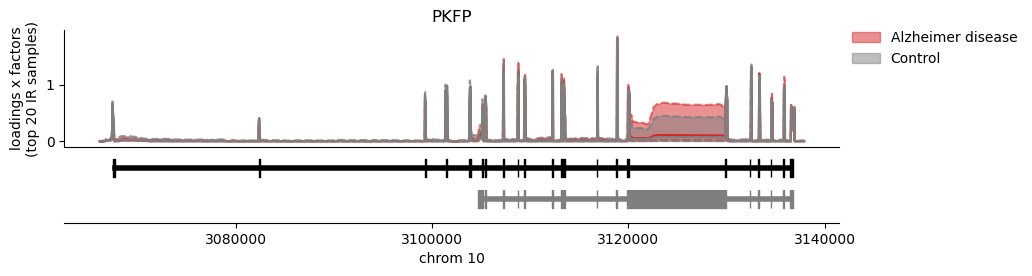

In [108]:
top_samples_ctrl = EL.loc[control_samples, ['factor_2', 'factor_4']].sum(axis=1).sort_values().index#[-20:]
top_samples_ad = EL.loc[ad_samples, ['factor_2', 'factor_4']].sum(axis=1).sort_values().index#[-20:]

LF_ad = np.array(EL.loc[ad_samples]).dot(np.array(np.array(rds['snmf_5']['ebpmf']['EF_smooth']).T))
LF_ctrl = np.array(EL.loc[control_samples]).dot(np.array(np.array(rds['snmf_5']['ebpmf']['EF_smooth']).T))

LF_ad_norm = np.divide(LF_ad.T, np.quantile(LF_ad, 0.99, axis=1)).T
LF_ctrl_norm = np.divide(LF_ctrl.T, np.quantile(LF_ctrl, 0.99, axis=1)).T

fig, axes = plt.subplots(nrows = 4, figsize=(10, 2.5), gridspec_kw={'height_ratios': [6, 1, 1, 0.1], 'hspace': 0.3})
LF_ad_norm_df = pd.DataFrame(LF_ad_norm)
LF_ad_norm_df.index = ad_samples#.intersection(dlpc_samples)


LF_ctrl_norm_df = pd.DataFrame(LF_ctrl_norm)
LF_ctrl_norm_df.index = control_samples#.intersection(dlpc_samples)

ax = axes[0]
top_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc[top_samples_ad[-1]])#[5000:8000]
bottom_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc[top_samples_ad[0]])#[5000:8000]
ax.fill_between(range(len(top_ad)), bottom_ad, top_ad, alpha=0.5, color='tab:red', label='Alzheimer disease')
ax.plot(top_ad, c='tab:red', linestyle='--', alpha=0.5)
ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0)),#[5000:8000], 
        c='tab:red')
ax.plot(bottom_ad, c='tab:red', linestyle='--', alpha=0.5)

print(len(top_samples_ad))


# ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0)))

top_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc[top_samples_ctrl[-1]])#[5000:8000]
bottom_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc[top_samples_ctrl[0]])#[5000:8000]
ax.fill_between(range(len(top_ad)), bottom_ctrl, top_ctrl, alpha=0.5, color='tab:gray', label='Control')


ax.plot(top_ctrl, c='tab:gray', linestyle='--', alpha=0.75)
ax.plot(np.array(LF_ctrl_norm_df.loc[top_samples_ctrl].rolling(5, axis=1).median().median(axis=0)),#[5000:8000], 
        c='tab:gray')
ax.plot(bottom_ctrl, c='tab:gray', linestyle='--', alpha=0.75)

ax.legend(frameon=False, bbox_to_anchor=(1, 1.1))

# ax.set_xlim((3111233, 3137801))





plot_isoform_annotations(snmf_exons.loc[snmf_exons.transcript_id.isin(['ENSG00000067057.isoform_1', 'ENSG00000067057.isoform_4'])], 
                         'ENSG00000067057', colores = ['black', 'tab:gray'], axes=axes[1:-1], lwidth=4)#, xlim=(3111233, 3137801))

# axes[1].set_xlim((3109900, 3139101))
# axes[2].set_xlim((3109900, 3139101))

axes[-3].set_xlim([3066503-4000, 3137800+3700])

axes[-2].set_xlim([3066503-4000, 3137800+3700])

axes[-1].set_xlim([3066503-4000, 3137800+3700])


xticks = [ 3080000, 3100000, 3120000, 3140000]
axes[-1].set_xticks(xticks)
axes[-1].set_xticklabels([str(x) for x in xticks])
axes[-1].spines[['top', 'right', 'left']].set_visible(False)
axes[-1].set_yticks([])
axes[-1].set_xlabel('chrom 10')
axes[0].set_xticks([])
axes[0].spines[['top', 'right']].set_visible(False)
axes[0].set_ylabel('loadings x factors\n(top 20 IR samples)')
axes[0].set_title('PKFP')
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)

plt.savefig('../code/scratch_figures/figure5/PKFP_LF_all_samples.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/PKFP_LF_all_samples.png', bbox_inches='tight', dpi=500)

44


/tmp/jobs/42979454/ipykernel_34040/2976881968.py:34: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  top_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc[top_samples_ad[-1]])#[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/2976881968.py:35: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  bottom_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc[top_samples_ad[0]])#[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/2976881968.py:38: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0)),#[5000:8000],
/tmp/jobs/42979454/ipykernel_34040/2976881968.py:46: FutureWarning: Support for axis=1 in DataFrame.rolling

44


/tmp/jobs/42979454/ipykernel_34040/2976881968.py:47: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  bottom_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc[top_samples_ctrl[0]])#[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/2976881968.py:52: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  ax.plot(np.array(LF_ctrl_norm_df.loc[top_samples_ctrl].rolling(5, axis=1).median().median(axis=0)),#[5000:8000],


['chr10:3066503', 'chr10:3137800']
chr10:3066503
chr10:3137800
booyah


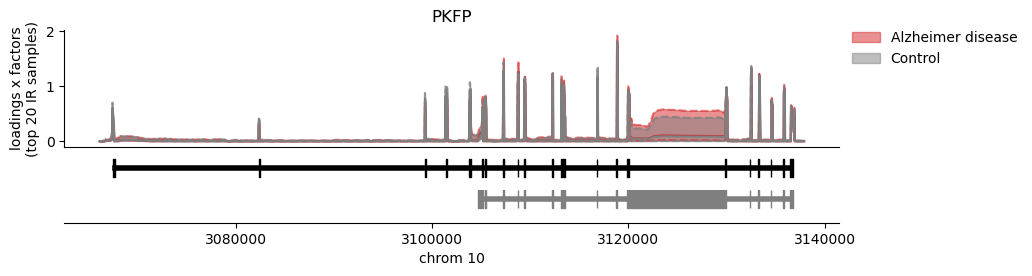

In [109]:
# top_samples_ctrl = EL.loc[control_samples.intersection(dlpc_samples), 'factor_4'].sort_values().index[-10:]
# top_samples_ad = EL.loc[ad_samples.intersection(dlpc_samples), 'factor_4'].sort_values().index[-10:]


top_samples_ctrl = EL.loc[control_samples.intersection(dlpc_samples), ['factor_2', 'factor_4']].sum(axis=1).sort_values().index#[-20:]
top_samples_ad = EL.loc[ad_samples.intersection(dlpc_samples), ['factor_2', 'factor_4']].sum(axis=1).sort_values().index#[-20:]

print(len(top_samples_ad))

LF_ad = np.array(EL.loc[ad_samples]).dot(np.array(np.array(rds['snmf_5']['ebpmf']['EF_smooth']).T))
LF_ctrl = np.array(EL.loc[control_samples]).dot(np.array(np.array(rds['snmf_5']['ebpmf']['EF_smooth']).T))

LF_ad_norm = np.divide(LF_ad.T, np.quantile(LF_ad, 0.99, axis=1)).T
LF_ctrl_norm = np.divide(LF_ctrl.T, np.quantile(LF_ctrl, 0.99, axis=1)).T

# top_samples_ctrl = EL.loc[control_samples, ['factor_2', 'factor_4']].sum(axis=1).sort_values().index#[-20:]
# top_samples_ad = EL.loc[ad_samples, ['factor_2', 'factor_4']].sum(axis=1).sort_values().index#[-20:]

LF_ad = np.array(EL.loc[ad_samples]).dot(np.array(np.array(rds['snmf_5']['ebpmf']['EF_smooth']).T))
LF_ctrl = np.array(EL.loc[control_samples]).dot(np.array(np.array(rds['snmf_5']['ebpmf']['EF_smooth']).T))

LF_ad_norm = np.divide(LF_ad.T, np.quantile(LF_ad, 0.99, axis=1)).T
LF_ctrl_norm = np.divide(LF_ctrl.T, np.quantile(LF_ctrl, 0.99, axis=1)).T

fig, axes = plt.subplots(nrows = 4, figsize=(10, 2.5), gridspec_kw={'height_ratios': [6, 1, 1, 0.1], 'hspace': 0.3})
LF_ad_norm_df = pd.DataFrame(LF_ad_norm)
LF_ad_norm_df.index = ad_samples#.intersection(dlpc_samples)


LF_ctrl_norm_df = pd.DataFrame(LF_ctrl_norm)
LF_ctrl_norm_df.index = control_samples#.intersection(dlpc_samples)

ax = axes[0]
top_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc[top_samples_ad[-1]])#[5000:8000]
bottom_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc[top_samples_ad[0]])#[5000:8000]
ax.fill_between(range(len(top_ad)), bottom_ad, top_ad, alpha=0.5, color='tab:red', label='Alzheimer disease')
ax.plot(top_ad, c='tab:red', linestyle='--', alpha=0.5)
ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0)),#[5000:8000], 
        c='tab:red')
ax.plot(bottom_ad, c='tab:red', linestyle='--', alpha=0.5)

print(len(top_samples_ad))

# ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0)))

top_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc[top_samples_ctrl[-1]])#[5000:8000]
bottom_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc[top_samples_ctrl[0]])#[5000:8000]
ax.fill_between(range(len(top_ad)), bottom_ctrl, top_ctrl, alpha=0.5, color='tab:gray', label='Control')


ax.plot(top_ctrl, c='tab:gray', linestyle='--', alpha=0.75)
ax.plot(np.array(LF_ctrl_norm_df.loc[top_samples_ctrl].rolling(5, axis=1).median().median(axis=0)),#[5000:8000], 
        c='tab:gray')
ax.plot(bottom_ctrl, c='tab:gray', linestyle='--', alpha=0.75)

ax.legend(frameon=False, bbox_to_anchor=(1, 1.1))

# ax.set_xlim((3111233, 3137801))





plot_isoform_annotations(snmf_exons.loc[snmf_exons.transcript_id.isin(['ENSG00000067057.isoform_1', 'ENSG00000067057.isoform_4'])], 
                         'ENSG00000067057', colores = ['black', 'tab:gray'], axes=axes[1:-1], lwidth=4)#, xlim=(3111233, 3137801))

# axes[1].set_xlim((3109900, 3139101))
# axes[2].set_xlim((3109900, 3139101))

axes[-3].set_xlim([3066503-4000, 3137800+3700])

axes[-2].set_xlim([3066503-4000, 3137800+3700])

axes[-1].set_xlim([3066503-4000, 3137800+3700])


xticks = [ 3080000, 3100000, 3120000, 3140000]
axes[-1].set_xticks(xticks)
axes[-1].set_xticklabels([str(x) for x in xticks])
axes[-1].spines[['top', 'right', 'left']].set_visible(False)
axes[-1].set_yticks([])
axes[-1].set_xlabel('chrom 10')
axes[0].set_xticks([])
axes[0].spines[['top', 'right']].set_visible(False)
axes[0].set_ylabel('loadings x factors\n(top 20 IR samples)')
axes[0].set_title('PKFP')
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)

plt.savefig('../code/scratch_figures/figure5/PKFP_LF_DLPC_all_samples.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/PKFP_LF_DLPC_all_samples.png', bbox_inches='tight', dpi=500)

/tmp/jobs/42979454/ipykernel_34040/3764384371.py:24: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  top_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc[top_samples_ad[-1]])#[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/3764384371.py:25: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  bottom_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc[top_samples_ad[0]])#[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/3764384371.py:28: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0)),#[5000:8000],
/tmp/jobs/42979454/ipykernel_34040/3764384371.py:36: FutureWarning: Support for axis=1 in DataFrame.rolling

10


/tmp/jobs/42979454/ipykernel_34040/3764384371.py:37: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  bottom_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc[top_samples_ctrl[0]])#[5000:8000]
/tmp/jobs/42979454/ipykernel_34040/3764384371.py:42: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  ax.plot(np.array(LF_ctrl_norm_df.loc[top_samples_ctrl].rolling(5, axis=1).median().median(axis=0)),#[5000:8000],


['chr10:3066503', 'chr10:3137800']
chr10:3066503
chr10:3137800
booyah


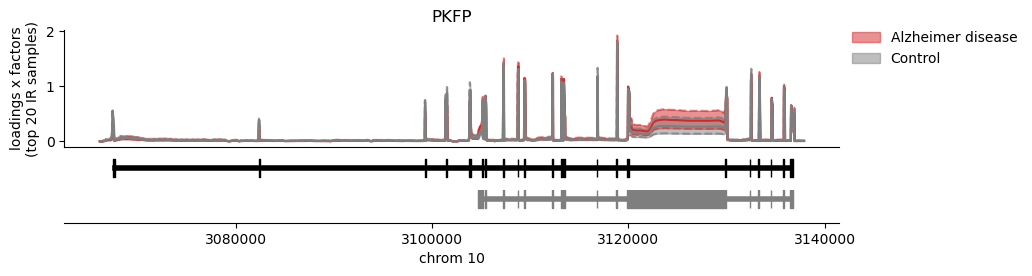

In [111]:
# top_samples_ctrl = EL.loc[control_samples.intersection(dlpc_samples), 'factor_4'].sort_values().index[-10:]
# top_samples_ad = EL.loc[ad_samples.intersection(dlpc_samples), 'factor_4'].sort_values().index[-10:]


top_samples_ctrl = EL.loc[control_samples.intersection(dlpc_samples), ['factor_2', 'factor_4']].sum(axis=1).sort_values().index[-10:]
top_samples_ad = EL.loc[ad_samples.intersection(dlpc_samples), ['factor_2', 'factor_4']].sum(axis=1).sort_values().index[-10:]

LF_ad = np.array(EL.loc[ad_samples]).dot(np.array(np.array(rds['snmf_5']['ebpmf']['EF_smooth']).T))
LF_ctrl = np.array(EL.loc[control_samples]).dot(np.array(np.array(rds['snmf_5']['ebpmf']['EF_smooth']).T))

LF_ad_norm = np.divide(LF_ad.T, np.quantile(LF_ad, 0.99, axis=1)).T
LF_ctrl_norm = np.divide(LF_ctrl.T, np.quantile(LF_ctrl, 0.99, axis=1)).T


fig, axes = plt.subplots(nrows = 4, figsize=(10, 2.5), gridspec_kw={'height_ratios': [6, 1, 1, 0.1], 'hspace': 0.3})
LF_ad_norm_df = pd.DataFrame(LF_ad_norm)
LF_ad_norm_df.index = ad_samples#.intersection(dlpc_samples)


LF_ctrl_norm_df = pd.DataFrame(LF_ctrl_norm)
LF_ctrl_norm_df.index = control_samples#.intersection(dlpc_samples)

ax = axes[0]
top_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc[top_samples_ad[-1]])#[5000:8000]
bottom_ad = np.array(LF_ad_norm_df.rolling(5, axis=1).median().loc[top_samples_ad[0]])#[5000:8000]
ax.fill_between(range(len(top_ad)), bottom_ad, top_ad, alpha=0.5, color='tab:red', label='Alzheimer disease')
ax.plot(top_ad, c='tab:red', linestyle='--', alpha=0.5)
ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0)),#[5000:8000], 
        c='tab:red')
ax.plot(bottom_ad, c='tab:red', linestyle='--', alpha=0.5)
print(len(top_samples_ad))


# ax.plot(np.array(LF_ad_norm_df.loc[top_samples_ad].rolling(5, axis=1).median().median(axis=0)))

top_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc[top_samples_ctrl[-1]])#[5000:8000]
bottom_ctrl = np.array(LF_ctrl_norm_df.rolling(5, axis=1).median().loc[top_samples_ctrl[0]])#[5000:8000]
ax.fill_between(range(len(top_ad)), bottom_ctrl, top_ctrl, alpha=0.5, color='tab:gray', label='Control')


ax.plot(top_ctrl, c='tab:gray', linestyle='--', alpha=0.75)
ax.plot(np.array(LF_ctrl_norm_df.loc[top_samples_ctrl].rolling(5, axis=1).median().median(axis=0)),#[5000:8000], 
        c='tab:gray')
ax.plot(bottom_ctrl, c='tab:gray', linestyle='--', alpha=0.75)

ax.legend(frameon=False, bbox_to_anchor=(1, 1.1))

# ax.set_xlim((3111233, 3137801))





plot_isoform_annotations(snmf_exons.loc[snmf_exons.transcript_id.isin(['ENSG00000067057.isoform_1', 'ENSG00000067057.isoform_4'])], 
                         'ENSG00000067057', colores = ['black', 'tab:gray'], axes=axes[1:-1], lwidth=4)#, xlim=(3111233, 3137801))

# axes[1].set_xlim((3109900, 3139101))
# axes[2].set_xlim((3109900, 3139101))

axes[-3].set_xlim([3066503-4000, 3137800+3700])

axes[-2].set_xlim([3066503-4000, 3137800+3700])

axes[-1].set_xlim([3066503-4000, 3137800+3700])


xticks = [ 3080000, 3100000, 3120000, 3140000]
axes[-1].set_xticks(xticks)
axes[-1].set_xticklabels([str(x) for x in xticks])
axes[-1].spines[['top', 'right', 'left']].set_visible(False)
axes[-1].set_yticks([])
axes[-1].set_xlabel('chrom 10')
axes[0].set_xticks([])
axes[0].spines[['top', 'right']].set_visible(False)
axes[0].set_ylabel('loadings x factors\n(top 20 IR samples)')
axes[0].set_title('PKFP')
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)

plt.savefig('../code/scratch_figures/figure5/PKFP_LF_DLPC_top_10.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure5/PKFP_LF_DLPC_top_10.png', bbox_inches='tight', dpi=500)